
Temperature  T is in J/kb



In [2]:
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
import random
import time
%matplotlib inline
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
lns = {'2d':4,'3d':6,'tri':6,'honey':3,'kagome':4,'fcc':12,'bcc':8} #square lattice is referred as 2d and cubic lattice as 3d

def initialize_p(ln,beta,J=1):
  #one good things is to initialise this with ln = 6 , the maximum number of neighbours possible from all lattices. This is 
  p = np.ones(ln+1)
  for i in range(1,ln+1):
    p[i] = np.exp(-2*i*J*beta)
  return p

## basic code for 2d lattice.
No need to run this

In [ ]:
def initial_state(n):    
    state = np.random.choice([1, -1], size=(n, n))
    return state
def step_update(state,p,J,H,acceptance,N = 10):  
    for i in range(N**2):
      a = np.random.randint(0, N)
      b = np.random.randint(0, N)
      s =  state[a, b]
      nb = state[(a+1)%N,b] + state[a,(b+1)%N] + state[(a-1)%N,b] + state[a,(b-1)%N]
      cost = 2*s*(J*nb + H)
      # print(nb,cost,np.exp(-cost*beta),rand())
      if cost < 0:
          state[a, b] = -state[a, b]
          acceptance+=1
      elif rand() < p[np.abs(nb)]:
          state[a, b] = -state[a, b]
          acceptance+=1
    return state,acceptance

def step_update_with_energy_mag(state,p,J,H,energy,mag,acceptance,N=10):
    for i in range(N**2):
      a = np.random.randint(0, N)
      b = np.random.randint(0, N)
      s =  state[a, b]
      nb = state[(a+1)%N,b] + state[a,(b+1)%N] + state[(a-1)%N,b] + state[a,(b-1)%N]
      cost = 2*s*(J*nb + H)
      if cost < 0:
        if state[a,b] == 1:
            mag-=2
        else:
          mag+=2
        state[a, b] = -state[a, b]
        acceptance+=1
        energy+=cost
      elif rand() < p[np.abs(nb)]:
        if state[a,b] == 1:
            mag-=2
        else:
          mag+=2
        state[a, b] = -state[a, b]
        acceptance+=1
        energy+=cost
    return state,energy,mag,acceptance

def calcEnergy(state,J,H):
    energy = 0
    for i in range(len(state)):
        for j in range(len(state)):
            S = state[i,j]
            nb = state[(i+1)%N, j] + state[i,(j+1)%N] + state[(i-1)%N, j] + state[i,(j-1)%N]
            energy += -nb*S
    return J*(energy/2.) + H*(np.sum(state))


## Important utility functions
Run these

In [4]:
def calcMag(state):
    return (np.sum(state))

def autocorrwithtau(x,T,method = 'naive'):
  N = len(x)
  #autocorrelation of a constant term will give nan as denominator (chi(0)) will be a constant
  if T>2 and T<2.5:
    nlags = 1000 #this should be changed with respect to temperature or lattice
    acr = acf(x,nlags)
  else:
    nlags = 50
    acr = acf(x,nlags) #default nlags is 40
  if np.isnan(acr).sum(): #nan is possible only when all the samples are same.constant signal (because denominator will be infinity)
      return 1 
  if method == 'naive':
    inv_e = 1/np.e
    for i in range(len(acr)):
      if acr[i]<inv_e: #this is a naive method, because at smaller temperatures it converges in few steps
        return i
    while nlags<N: #if it did not converge within those steps, calculate for more acf
      nlags*=10
      acr = acf(x,nlags = 10000)
      for i in range(len(acr)):
        if acr[i]<inv_e: 
          return i
    try:
      sl,incpt = np.polyfit(np.arange(len(acr[:i-1])),np.log(acr[:i-1]),1) #linear fit. sl is slope
    except:
      return 1
    
    return int(-1/sl)

  else: #not naive method. fits a lin to log(tau)
    inv_e = 1/np.e
    for i in range(1,len(acr)):
      if acr[i]<0 or acr[i]>acr[i-1]: 
        break
    # if acr[i]>0:
    #   i = i+1
    try:
      sl,incpt = np.polyfit(np.arange(len(acr[:i-1])),np.log(acr[:i-1]),1) #linear fit. sl is slope
    except:
      return 1
    # '''uncomment the following lines if you want to see graphs'''
    # plt.plot(np.arange(i-1),acr[:i-1],label ='normal')
    # plt.plot(np.arange(i-1),np.log(acr[:i-1]),label = 'log')
    # plt.show()
    # plt.legend()
    return (-1.0/sl)

def calc_constants(N,steps,lattice = '2d'):
  if lattice =='3d':
      n1, n2  = 1.0/(steps*(N**3)), 1.0/((steps**2)*(N**3)) 
      n3 = N**3
  elif lattice == '1d':
      n1, n2, n3  = 1.0/(steps*N), 1.0/(steps*steps*N) ,N
  elif lattice == 'kagome':
      n3 =   int((3/4)*N**2)
      n1, n2 = 1.0/(steps*(n3)), 1.0/((steps**2)*(n3))
  elif lattice in ['fcc','bcc']:
      n1, n2  = 1.0/(steps*(N**3)), 1.0/((steps**2)*(N**3)) 
      n3 = N**3
  else: 
      n1, n2, n3  = 1.0/(steps*(N**2)), 1.0/((steps**2)*(N**2)) ,N**2
  return n1,n2,n3

def nbrs(i,n,lattice):
  if lattice == 'fcc':
    return [i+1,i-1,i+n,i-n,i+n**2,i-n**2,i+(n-1),i-(n-1),i+(n**2-1),i-(n**2-1),i+(n**2-n),i-(n**2-n)]
  elif lattice == 'bcc':
    return [i+1,i-1,i+n,i-n,i+n**2,i-n**2,i+(n**2+n+1),i-(n**2+n+1)]

def initial_state(n,lattice = '2d'):
  if lattice in ['2d','honey','tri']:    
    state = np.random.choice([1, -1], size=(n, n))
  elif lattice == '1d':
    state = np.random.choice([-1,1], size = (n))
  elif lattice == '3d':
    state = np.random.choice([-1,1],size = (n,n,n))
  elif lattice == 'kagome':
    state = np.random.choice([1, -1], size=(n, n))
    state[1::2, 1::2] = 0
  elif lattice in ['fcc','bcc']:
    return np.random.choice([1,-1],size = n**3)
  return state



def step_update_with_energy_mag(state,p,J,H,energy,mag,acceptance,N=10,lattice = '2d'):
# def step_update_with_energy_mag(state,beta,J,H,energy,mag,acceptance,N=10,lattice = '2d'):
    if lattice == '3d':
      for i in range(N**3):
        a = np.random.randint(0, N)
        b = np.random.randint(0, N)
        c = np.random.randint(0,N)
        s = state[a,b,c]
        nb = state[(a+1)%N,b,c] + state[(a-1)%N,b,c] + state[a,(b+1)%N,c]  + state[a,(b-1)%N,c] + state[a,b,(c+1)%N]  + state[a,b,(c-1)%N]
        cost = 2*s*(J*nb + H)
    # print(nb,cost,np.exp(-cost*beta),rand())
        if cost <= 0:
            acceptance+=1
            if state[a,b,c] == 1:
                mag-=2
            else:
                mag+=2
            state[a,b,c] = -state[a,b,c]
            energy+=cost
        elif rand() < p[np.abs(nb)]:
            # print(p[np.abs(nb)], np.exp(-cost*beta))
            # assert p[np.abs(nb)] == np.exp(-cost*beta)
            acceptance+=1
            if state[a,b,c] == 1:
                mag-=2
            else:
                mag+=2
            state[a,b,c] = -state[a,b,c]
            energy+=cost
      return state,energy,mag,acceptance
    elif lattice in ['fcc','bcc']:
      for i in range(N**3):
        a = np.random.randint(0, N**3)
        s =  state[a]
        n3 = N**3
        nb = 0
        for nbr in nbrs(a,N,lattice):
          nb += state[nbr%n3]
        cost = 2*s*(J*nb + H)
        if cost <= 0:
            if state[a] == 1:
                mag-=2
            else:
              mag+=2
            state[a] = -state[a]
            energy+=cost
            acceptance+=1
      # elif rand() < np.exp(-cost*beta):
        elif rand() < p[np.abs(nb)]:
            if state[a] == 1:
                mag-=2
            else:
              mag+=2
            state[a] = -state[a]
            energy+=cost
            acceptance+=1
      return state,energy,mag,acceptance
    for i in range(N**2):
      a = np.random.randint(0, N)
      b = np.random.randint(0, N)
      if lattice == '2d':
          s =  state[a, b]
          nb = state[(a+1)%N,b] + state[a,(b+1)%N] + state[(a-1)%N,b] + state[a,(b-1)%N]
      elif lattice == '1d':
          s = state[a]
          nb = state[(a+1)%N] + state[(a-1)%N]
        
      elif lattice == 'tri':
          s =  state[a, b]
          nb = state[(a+1)%N,b] + state[(a-1)%N,b] + state[a,(b+1)%N]  + state[a,(b-1)%N] + state[(a+1)%N,(b+1)%N]  + state[(a-1)%N,(b-1)%N]
      elif lattice == 'honey':
          # a = np.random.randint(0, N-1)
          s =  state[a, b]
          if (not a%2) and (not b%2):
            nb = state[a,(b-1)%N] + state[a,(b+1)%N] + state[(a-1)%N,b]
          elif (not a%2) and b%2:
            nb = state[a,(b-1)%N] + state[a,(b+1)%N] + state[(a+1)%N,b]
          elif a%2 and (not b%2):
            nb = state[a,(b-1)%N] + state[a,(b+1)%N] + state[(a+1)%N,b]
          elif a%2 and b%2:
            nb = state[a,(b-1)%N] + state[a,(b+1)%N] + state[(a-1)%N,b]
      elif lattice == 'kagome':
        s =  state[a, b]
        if a%2 and b%2:
          continue
        elif (not a%2) and (not b%2):
          nb = state[(a+1)%N,b] + state[a,(b+1)%N] + state[(a-1)%N,b] + state[a,(b-1)%N]
        elif (not a%2) and (b%2):
          nb = state[(a+1)%N,(b+1)%N] +  state[(a-1)%N,(b-1)%N] + state[a,(b+1)%N] + state[a,(b-1)%N]
        elif (a%2)  and (not b%2):
          nb = state[(a+1)%N,(b+1)%N] +  state[(a-1)%N,(b-1)%N] + state[(a+1)%N,b] + state[(a-1)%N,b]
      cost = 2*s*(J*nb + H)
      if cost <= 0:
        if lattice in ['2d','tri','honey','kagome']:
            if state[a,b] == 1:
                mag-=2
            else:
              mag+=2
            state[a, b] = -state[a, b]
        elif lattice == '1d':
            if state[a] == 1:
                mag-=2
            else:
              mag+=2
            state[a] = -state[a]
        acceptance+=1
        energy+=cost
      elif rand() < p[np.abs(nb)]:
        # print(p[np.abs(nb)], np.exp(-cost*beta))
        # assert p[np.abs(nb)] == np.exp(-cost*beta)
        if lattice in ['2d','tri','honey','kagome']:
            if state[a,b] == 1:
                mag-=2
            else:
              mag+=2
            state[a, b] = -state[a, b]
        elif lattice == '1d':
            if state[a] == 1:
                mag-=2
            else:
              mag+=2
            state[a] = -state[a]
        acceptance+=1
        energy+=cost
    return state,energy,mag,acceptance

def calcEnergy(state,J,H,lattice = '2d'):
    energy = 0
    N = state.shape[0]
    if lattice == '2d':
      for i in range(len(state)):
          for j in range(len(state)):
              S = state[i,j]
              nb = state[(i+1)%N, j] + state[i,(j+1)%N] + state[(i-1)%N, j] + state[i,(j-1)%N]
              energy += -nb*S
    elif lattice == '3d':
      for i in range(len(state)):
          for j in range(len(state)):
              for k in range(len(state)):
                  S = state[i,j,k]
                  nb = state[(i+1)%N, j,k] + state[(i-1)%N, j,k] + state[i,(j+1)%N,k]  + state[i,(j-1)%N,k] + state[i, j,(k+1)%N] + state[i, j,(k-1)%N] 
                  energy += -nb*S
    elif lattice in ['fcc','bcc']:
      N = len(state)
      cuberoots = {1: 1, 8: 2, 27: 3, 64: 4, 125: 5, 216: 6, 343: 7, 512: 8, 729: 9, 1000: 10}
      n = cuberoots[N]
      for i in range(N):
        S = state[i]
        nb = 0
        for nbr in nbrs(i,n,lattice):
          nb+= state[nbr%N]
        energy+= (-nb*S)
    elif lattice == '1d':
        for i in range(len(state)):
          # for j in range(len(state)):
            S = state[i]
            nb = state[(i+1)%N] + state[(i-1)%N] 
            energy += -nb*S
    elif lattice == 'tri':
        for i in range(len(state)):
            for j in range(len(state)):
                S = state[i,j]
                nb = state[(i+1)%N, j] + state[(i-1)%N, j] + state[i,(j+1)%N] +  state[i,(j-1)%N] +state[(i+1)%N, (j+1)%N] + state[(i-1)%N, (j-1)%N]
                energy += -nb*S
    elif lattice == 'honey':
      for a in range(state.shape[0]):
          for b in range(state.shape[1]):
              S =  state[a, b]
              if (not a%2) and (not b%2):
                nb = state[a,(b-1)%N] + state[a,(b+1)%N] + state[(a-1)%N,b]
              elif (not a%2) and b%2:
                nb = state[a,(b-1)%N] + state[a,(b+1)%N] + state[(a+1)%N,b]
              elif a%2 and (not b%2):
                nb = state[a,(b-1)%N] + state[a,(b+1)%N] + state[(a+1)%N,b]
              elif a%2 and b%2:
                nb = state[a,(b-1)%N] + state[a,(b+1)%N] + state[(a-1)%N,b]
              energy += -nb*S
    elif lattice == 'kagome':
      for a in range(state.shape[0]):
          for b in range(state.shape[1]):
            S =  state[a, b]
            if a%2 and b%2:
              nb = 0
            elif (not a%2) and (not b%2):
              nb = state[(a+1)%N,b] + state[a,(b+1)%N] + state[(a-1)%N,b] + state[a,(b-1)%N]
            elif (not a%2) and (b%2):
              nb = state[(a+1)%N,(b+1)%N] +  state[(a-1)%N,(b-1)%N] + state[a,(b+1)%N] + state[a,(b-1)%N]
            elif (a%2)  and (not b%2):
              nb = state[(a+1)%N,(b+1)%N] +  state[(a-1)%N,(b-1)%N] + state[(a+1)%N,b] + state[(a-1)%N,b]
            energy += -nb*S
    return J*(energy/2.) + H*(np.sum(state))

### not so important functions

In [6]:
def step_update(state,p,J,H,acceptance,N = 10,lattice = '2d'):  
    '''this is a subsitute for function step_update_with_energy_mag
    This doesn't update energy or magnetisation. so, takes less computation
    Can use this during equilibrium'''
    if lattice == '3d':
      for i in range(N**3):
        a = np.random.randint(0, N)
        b = np.random.randint(0, N)
        c = np.random.randint(0,N)
        s = state[a,b,c]
        nb = state[(a+1)%N,b,c] + state[(a-1)%N,b,c] + state[a,(b+1)%N,c]  + state[a,(b-1)%N,c] + state[a,b,(c+1)%N]  + state[a,b,(c-1)%N]
        cost = 2*s*(J*nb + H)
        if cost <= 0:
            state[a,b,c] = -state[a,b,c]
            acceptance+=1
        elif rand() < p[np.abs(nb)]:
          state[a, b,c] = -state[a, b,c]
          acceptance+=1
      return state,acceptance
    elif lattice in ['fcc','bcc']:
      for i in range(N**3):
        a = np.random.randint(0, N**3)
        s =  state[a]
        n3 = N**3
        nb = 0
        for nbr in nbrs(a,n,lattice):
          nb += state[nbr%n3]
        cost = 2*s*(J*nb + H)
        if cost <= 0:
            state[a] = -state[a]
            acceptance+=1
      # elif rand() < np.exp(-cost*beta):
        elif rand() < p[np.abs(nb)]:
            state[a] = -state[a]
            acceptance+=1
      return state,acceptance
      
    for i in range(N**2):
      a = np.random.randint(0, N)
      b = np.random.randint(0, N)
      if lattice == '2d':
          s =  state[a, b]
          nb = state[(a+1)%N,b] + state[a,(b+1)%N] + state[(a-1)%N,b] + state[a,(b-1)%N]
      elif lattice == '1d':
          s = state[a]
          nb = state[(a+1)%N] + state[(a-1)%N]
          
      elif lattice == 'tri':
          s =  state[a, b]
          nb = state[(a+1)%N,b] + state[(a-1)%N,b] + state[a,(b+1)%N]  + state[a,(b-1)%N] + state[(a+1)%N,(b+1)%N]  + state[(a-1)%N,(b-1)%N]
      elif lattice == 'honey':
          # a = np.random.randint(0, N-1)
          s =  state[a, b]
          if (not a%2) and (not b%2):
            nb = state[a,(b-1)%N] + state[a,(b+1)%N] + state[(a-1)%N,b]
          elif (not a%2) and b%2:
            nb = state[a,(b-1)%N] + state[a,(b+1)%N] + state[(a+1)%N,b]
          elif a%2 and (not b%2):
            nb = state[a,(b-1)%N] + state[a,(b+1)%N] + state[(a+1)%N,b]
          elif a%2 and b%2:
            nb = state[a,(b-1)%N] + state[a,(b+1)%N] + state[(a-1)%N,b]
      elif lattice == 'kagome':
          s =  state[a, b]
          if a%2 and b%2:
            continue
          elif (not a%2) and (not b%2):
            nb = state[(a+1)%N,b] + state[a,(b+1)%N] + state[(a-1)%N,b] + state[a,(b-1)%N]
          elif (not a%2) and (b%2):
            nb = state[(a+1)%N,(b+1)%N] +  state[(a-1)%N,(b-1)%N] + state[a,(b+1)%N] + state[a,(b-1)%N]
          elif (a%2)  and (not b%2):
            nb = state[(a+1)%N,(b+1)%N] +  state[(a-1)%N,(b-1)%N] + state[(a+1)%N,b] + state[(a-1)%N,b]
      cost = 2*s*(J*nb + H)
      # print(nb,cost,np.exp(-cost*beta),rand())
      if cost <= 0:
          if lattice in ['2d','tri','honey','kagome']:
              state[a, b] = -state[a, b]
          elif lattice == '1d':
              state[a] = -state[a]
          acceptance+=1
      elif rand() < p[np.abs(nb)]:
          if lattice in ['2d','tri','honey','kagome']:
              state[a, b] = -state[a, b]
          elif lattice == '1d':
              state[a] = -state[a]
          acceptance+=1
    return state,acceptance

# Implementations

## finding correlation times for fixed lattice at different temperatures

In [ ]:
import time
start_time = time.time()
lattice = 'bcc'
N = 10
steps = int(1e4)
begin_steps = int(1e3)
J = 1
H = 0
num_t = 20 #number of temperature steps
start_t = 2.5 #starting temperature
end_t = 4.4 #ending temperature
Temps = np.linspace(start_t,end_t, num_t)
taus = np.zeros(shape = (len(Ns),5))
taus1 = np.zeros(shape = (len(Ns),5))
n1,n2,n3 = calc_constants(N,steps,lattice)

for num in range(num_t):
    T = Temps[num]
    # print(T,num)
    iT = 1/T
    beta = iT
    iT2 = iT**2
    p = initialize_p(ln = lns[lattice],beta = iT)
    E1s, M1s,E2s,M2s= np.zeros(steps) , np.zeros(steps),np.zeros(steps), np.zeros(steps)
    E1 = M1 = E2 = M2  = M3 = acceptance = 0
    state = initial_state(N,lattice)
    ene = calcEnergy(state,J,H,lattice)
    mag = calcMag(state)
    for i in range(steps):
        E1s[i],M1s[i],E2s[i],M2s[i] = ene/n3,mag/n3,ene*2/n3,mag*2/n3
        state,ene,mag,acceptance = step_update_with_energy_mag(state,p,J,H,ene,mag,acceptance,N,lattice)   
        # state,ene,mag,acceptance = step_update_with_energy_mag(state,iT,J,H,ene,mag,acceptance,N,lattice)   
    plt.plot(np.arange(steps),E1s,M1s)
    plt.show()
    print(time.time()-start_time,"start")
    taus[num,0:4]  = np.array([autocorrwithtau(E1s[begin_steps:],T),autocorrwithtau(E2s[begin_steps:],T),autocorrwithtau(M1s[begin_steps:],T),autocorrwithtau(M2s[begin_steps:],T)])
    taus[num,4] = max(taus[num,0:4])
    print(time.time()-start_time,"naive")
    taus1[num,0:4]  = np.array([autocorrwithtau(E1s[begin_steps:],T,1),autocorrwithtau(E2s[begin_steps:],T,1),autocorrwithtau(M1s[begin_steps:],T,1),autocorrwithtau(M2s[begin_steps:],T,1)])
    taus1[num,4] = max(taus1[num,0:4])
    print(taus[num,:],taus1[num])
np.savez('taus for {} system diff Temps size {}'.format(lattice,N), taus = taus, taus1 = taus1, Ns = Ns)
#analysed later

In [ ]:
plt.plot(Temps,taus[:,4])

## finding correlation times at fixed temperature for different size

In [ ]:
import time
start_time = time.time()
lattice = 'bcc' #lattice you want to run for
# Ns      = [6,10,14,22,30,34]   #  size of the lattice, N x N
Ns = [2,4,6]
steps = int(1e3)
begin_steps = int(1e2) #equilibrium steps
J = 1
H = 0
T= 6.2 #critical temperature (temperature where the correlation time is maximum for a fixed lattice)
# T = 9.4
# T = 2.1
iT = 1/T
beta = iT
iT2 = iT**2
p = initialize_p(ln = lns[lattice],beta = iT)
taus = np.zeros(shape = (len(Ns),5))
taus1 = np.zeros(shape = (len(Ns),5))

for num in range(len((Ns))):
    # print(num)
    N = Ns[num]
    # print(N)
    
    E1s, M1s,E2s,M2s= np.zeros(steps) , np.zeros(steps),np.zeros(steps), np.zeros(steps)
    E1 = M1 = E2 = M2  = M3 = acceptance = 0
    state = initial_state(N,lattice)
    n1,n2,n3 = calc_constants(N,steps,lattice)
    ene = calcEnergy(state,J,H,lattice)
    mag = calcMag(state)
    for i in range(steps):
        E1s[i],M1s[i],E2s[i],M2s[i] = ene/n3,mag/n3,ene*2/n3,mag*2/n3
        state,ene,mag,acceptance = step_update_with_energy_mag(state,p,J,H,ene,mag,acceptance,N,lattice)   
        # state,ene,mag,acceptance = step_update_with_energy_mag(state,iT,J,H,ene,mag,acceptance,N,lattice)   
    plt.plot(np.arange(steps),E1s,M1s)
    plt.show()
    print(time.time()-start_time,"start")
    taus[num,0:4]  = np.array([autocorrwithtau(E1s[begin_steps:],T),autocorrwithtau(E2s[begin_steps:],T),autocorrwithtau(M1s[begin_steps:],T),autocorrwithtau(M2s[begin_steps:],T)])
    taus[num,4] = max(taus[num,0:4])
    print(time.time()-start_time,"naive")
    taus1[num,0:4]  = np.array([autocorrwithtau(E1s[begin_steps:],T,1),autocorrwithtau(E2s[begin_steps:],T,1),autocorrwithtau(M1s[begin_steps:],T,1),autocorrwithtau(M2s[begin_steps:],T,1)])
    taus1[num,4] = max(taus1[num,0:4])
    print(taus[num,:],taus1[num])
np.savez('taus for {} system diff Ls'.format(lattice), taus = taus, taus1 = taus1, Ns = Ns)
#this saved file can be analysed later

In [ ]:
#analysis in simple manner is here
plt.plot(np.log(Ns),np.log(taus[:,4]))
np.polyfit(np.log(Ns),np.log(taus[:,4]),1)

## taking observation

one good way is to calculate the maximum correlation time  from above boxes and make dictionary kind of thing so it can be sampled at thos points

In [ ]:
#some b_taus (biggest taus stored here)
tau_latt = {'2d':450,'3d':450,'tri':343,'honey':495}

In [ ]:
lattice = '2d'
N       = 10   #  size of the lattice, N x N
begin_steps = int(1e3)
b_tau = tau_latt[lattice] #b_tau is biggest tau
n_obs= 100
steps = int(b_tau*n_obs*2) #sampling at every 2tau
num_t = 31 #number of temperatures
J = 1
H = 0
start_t = 0.5 #starting temperature
end_t = 3.5 #ending temperature


Temps  = np.linspace(start_t,end_t, num_t)
Energs,Mags,Capheats,Xs,acceptors = np.zeros(num_t), np.zeros(num_t), np.zeros(num_t), np.zeros(num_t),np.zeros(num_t)
# Energserrors, Magerros, Capheat_errors, X_erros =  np.zeros(num_t), np.zeros(num_t), np.zeros(num_t), np.zeros(num_t)
E2ss,M2ss= np.zeros(num_t) , np.zeros(num_t)
taus = np.zeros(shape = (num_t,5),dtype = int)
Energ1s,Energ2s,Mag1s,Mag2s = np.zeros(shape = (num_t,n_obs)),np.zeros(shape = (num_t,n_obs)),np.zeros(shape = (num_t,n_obs)),np.zeros(shape = (num_t,n_obs))
n1,n2,n3 = calc_constants(N,steps,lattice)

for temp in range(num_t):
    E1s, M1s,E2s,M2s= np.zeros(begin_steps+steps) , np.zeros(begin_steps+steps),np.zeros(begin_steps+steps), np.zeros(begin_steps+steps)
    # print(temp) #uncomment for knowing prgress
    E1 = M1 = E2 = M2  = M3 = acceptance= 0
    state = initial_state(N,lattice)
    iT=1.0/Temps[temp]; 
    iT2=iT*iT;
    p = initialize_p(ln = lns[lattice],beta = iT)
    ene = calcEnergy(state,J,H,lattice)
    mag = calcMag(state)
    # print(ene/n3,mag/n3)
    for i in range(begin_steps + steps):
        E1s[i],M1s[i],E2s[i],M2s[i] = ene/n3,mag/n3,ene**2/n3,mag**2/n3
        # state,ene,mag,acceptance = step_update_with_energy_mag(state,iT,J,H,ene,mag,acceptance,N,lattice)       
        state,ene,mag,acceptance = step_update_with_energy_mag(state,p,J,H,energy,mag,acceptance,N,lattice )
    Energ1s[temp,:] = E1s[begin_steps::2*b_tau]
    Energ2s[temp,:] = E2s[begin_steps::2*b_tau]
    Mag1s[temp,:] =  M1s[begin_steps::2*b_tau]
    Mag2s[temp,:] =  M2s[begin_steps::2*b_tau]


    acceptors[temp] = acceptance/(begin_steps+steps)

    # Energs[temp] = np.mean(Energ1s[temp,:])
    # Mags[temp] = np.mean(Mag1s[temp,:])
    # E2ss[temp] = np.mean(Energ2s[temp,:])
    # M2ss[temp] = np.mean(Mag2s[temp,:])
    # Capheats[temp] = (E2ss[temp]/n_obs - (Energs[temp]**2/(n_obs**2))*n3)*iT2
    # Xs[temp] = (M2ss[temp]/n_obs - (Mags[temp]**2/(n_obs**2)*n3))*iT
np.savez('{}_{}_{}'.foramt(lattice,N,steps), Energ1s = Energ1s, Energ2s = Energ2s, Mag1s = Mag1s, Mag2s = Mag2s, temps = Temps, acceptors = acceptors)
#this can be analysed later


## check autocorrelation function. and find the slope of log of it to find correlation time

In [ ]:
lattice = '2d'
Ns      = [10]   #  size of the lattice, N x N
steps = int(1e3)

J = 1
H = 0
T =  2
iT = 1/T
iT2 = iT**2

p = initialize_p(ln = lns[lattice],beta = iT)

taus = np.zeros(shape = (len(Ns),5),dtype = int)
taus1 = np.zeros(shape = (len(Ns),5),dtype = int)
# np.exp(-cost*beta)
print(np.exp(np.arange(lns[lattice])*(-2*J*iT)),p)

for num in range(len((Ns))):
    N = Ns[num]
    n1,n2,n3 = calc_constants(N,steps,lattice)
    E1s, M1s,E2s,M2s= np.zeros(steps) , np.zeros(steps),np.zeros(steps), np.zeros(steps)
    E1 = M1 = E2 = M2  = M3 = acceptance = 0
    state = initial_state(N)
    iT2=iT*iT;
                    
    ene = calcEnergy(state,J,H)
    mag = calcMag(state)
    for i in range(steps):
        E1s[i],M1s[i],E2s[i],M2s[i] = ene/n3,mag/n3,ene**2/n3,mag**2/n3
        state,ene,mag,acceptance = step_update_with_energy_mag(state,p,ene,mag,acceptance,N)   
        # state,ene,mag,acceptance = step_update_with_energy_mag(state,iT,J,H,ene,mag,acceptance,N)   
    plt.plot(np.arange(steps),E1s,M1s)
    plt.show()
    # taus[num,0:4]  = np.array([autocorrwithtau(E1s,T),autocorrwithtau(E2s,T),autocorrwithtau(M1s,T),autocorrwithtau(M2s,T)])
    # taus[num,4] = max(taus[num,0:4])
    taus1[num,0:4]  = np.array([autocorrwithtau(E1s,T,1),autocorrwithtau(E2s,T,1),autocorrwithtau(M1s,T,1),autocorrwithtau(M2s,T,1)])
    taus1[num,4] = max(taus1[num,0:4])
    print(taus[num,:],taus1[num])
np.savez('taus for lattice system diff Ls', taus = taus, taus1 = taus1, Ns = Ns)

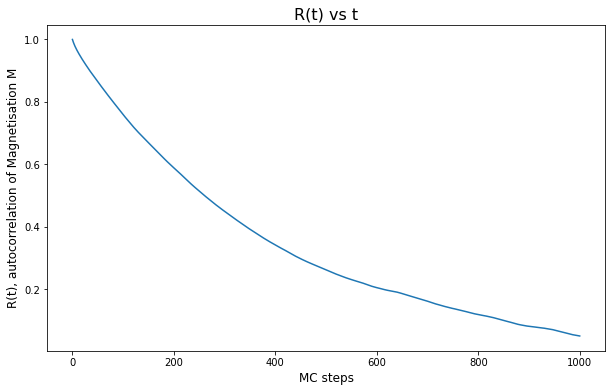

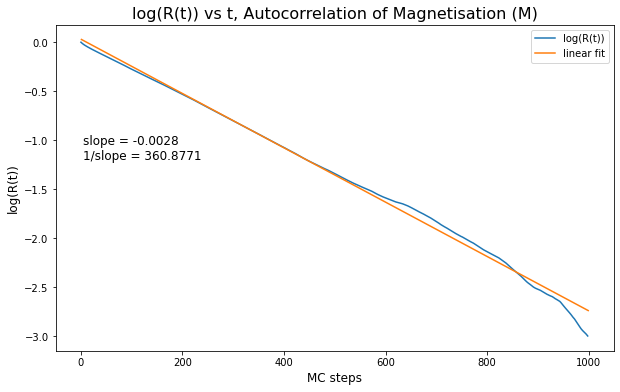

In [ ]:
# x = acf(M1s[2000:],nlags = 1000)
plt.figure(figsize= (10,6))
plt.plot(np.arange(1001),x)
plt.xlabel('MC steps',fontsize = 12)
plt.ylabel('R(t), autocorrelation of Magnetisation M',fontsize = 12)
plt.title('R(t) vs t',fontsize = 16)
# plt.show()
plt.savefig('autocorrelation mag 2d 10 2.26.png')

plt.figure(figsize= (10,6))
plt.plot(np.arange(i-1),lgx, label = 'log(R(t))')
plt.plot(np.array([1,i-1]),a*np.array([1,i-1])+b, label = 'linear fit')
plt.legend()
plt.xlabel('MC steps',fontsize = 12)
plt.ylabel('log(R(t))',fontsize = 12)
plt.title('log(R(t)) vs t, Autocorrelation of Magnetisation (M)',fontsize = 16)
plt.text(3.5,-1.2,'slope = {:.4f} \n1/slope = {:.4f}'.format(a,-1/a), fontsize = 12)
# plt.show()
plt.savefig('log autocorrelation mag 2d 10 2.26.png')

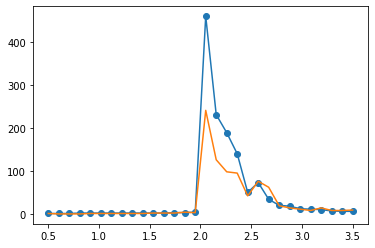

In [ ]:
# '''with equilibrium steps and  using previous configuration for l=10'''
# plt.plot(Temps,taus[:,4])
# plt.scatter(Temps,taus[:,4])
# plt.plot(Temps,taus1[:,4])

# wolff

## utility functions 
run these

In [ ]:
def ngbr(i,j,N,lattice = '2d',k=0):
  if lattice =='2d':
    return [((i+1)%N,j),((i-1)%N,j),(i,(j+1)%N),(i,(j-1)%N)]
  elif lattice == '3d':
    return [((i+1)%N,j,k),((i-1)%N,j,k),(i,(j+1)%N,k),(i,(j-1)%N,k),(i,j,(k+1)%N),(i,j,(k-1)%N)]
  elif lattice == 'tri':
    return [((i+1)%N,j),((i-1)%N,j),(i,(j+1)%N),(i,(j-1)%N),((i+1)%N,(j+1)%N),((i-1)%N,(j-1)%N)]
  elif lattice == 'honey':
    if (not i%2) and (not j%2):
      return [(i,(j-1)%N),(i,(j+1)%N),((i-1)%N,j)]
    elif (not i%2) and j%2:
      return [(i,(j-1)%N),(i,(j+1)%N),((i+1)%N,j)]
    elif i%2 and (not j%2):
      return [(i,(j-1)%N),(i,(j+1)%N),((i+1)%N,j)]
    else:
      return [(i,(j-1)%N),(i,(j+1)%N),((i-1)%N,j)]
  elif lattice == 'kagome':
    a,b =i, j

    if a%2 and b%2:
      return []
    elif (not a%2) and (not b%2):
      return[[(a+1)%N,b],[a,(b+1)%N] ,[(a-1)%N,b] ,[a,(b-1)%N]]
    elif (not a%2) and (b%2):
      return [[(a+1)%N,(b+1)%N] ,[(a-1)%N,(b-1)%N],[a,(b+1)%N] ,[a,(b-1)%N]]
    elif (a%2)  and (not b%2):
      return [[(a+1)%N,(b+1)%N] ,[(a-1)%N,(b-1)%N] ,[(a+1)%N,b] ,[(a-1)%N,b]]
  elif lattice == 'fcc':
    n = N
    n3 = n**3
    return [(i+1)%n3,(i-1)%n3,(i+n)%n3,(i-n)%n3,(i+n**2)%n3,(i-n**2)%n3,(i+(n-1))%n3,(i-(n-1))%n3,(i+(n**2-1))%n3,(i-(n**2-1))%n3,(i+(n**2-n))%n3,(i-(n**2-n))%n3]
  elif lattice == 'bcc':
    n = N
    n3 = n**3
    return [(i+1)%n3,(i-1)%n3,(i+n)%n3,(i-n)%n3,(i+n**2)%n3,(i-n**2)%n3,(i+(n**2+n+1))%n3,(i-(n**2+n+1))%n3]



def wolff_step(state,beta,p,N,lattice):
    if lattice in ['2d','tri','honey','kagome']:
      a = np.random.randint(0, N)
      b = np.random.randint(0, N)
      
      if lattice == 'kagome':
        flag = (a%2 and b%2)
        #flag = 0
        while flag:
          a = np.random.randint(0, N)
          b = np.random.randint(0, N)
          flag = a%2 and b%2

      # p  = 1.0 - np.exp(-2*beta)
      s =  state[a, b]
      Pocket, Cluster = [(a,b)], [(a,b)]
      while Pocket != []:
          # print(Pocket)
          j = random.choice(Pocket)
          nbr = ngbr(j[0],j[1],N,lattice)
          for l in nbr:
              if state[l[0],l[1]] == state[j[0],j[1]] and (l not in Cluster) and (rand() < p):
                  Pocket.append(l)
                  Cluster.append(l)
                  # state[l[0],l[1]] *= -1
          Pocket.remove(j)
      # print(Cluster)
      for j in Cluster:
          state[j[0],j[1]] *= -1
      return state,len(Cluster)
    elif lattice == '3d':
      a = np.random.randint(0, N)
      b = np.random.randint(0, N)
      c = np.random.randint(0, N)
      # p  = 1.0 - np.exp(-2*beta)
      s =  state[a, b,c]
      Pocket, Cluster = [(a,b,c)], [(a,b,c)]
      while Pocket != []:
          # print(Pocket)
          j = random.choice(Pocket)
          nbr = ngbr(j[0],j[1],N,lattice,j[2])
          for l in nbr:
              if state[l[0],l[1],l[2]] == state[j[0],j[1],j[2]] and (l not in Cluster) and (rand() < p):
                  Pocket.append(l)
                  Cluster.append(l)
                  # state[l[0],l[1]] *= -1
          Pocket.remove(j)
      # print(Cluster)
      for j in Cluster:
          state[j[0],j[1],j[2]] *= -1
      return state,len(Cluster)
    elif lattice in ['fcc','bcc']:
      n3 = N**3
      a = np.random.randint(0, n3)
      # p  = 1.0 - np.exp(-2*beta)
      s =  state[a]
      Pocket, Cluster = [a], [a]
      while Pocket != []:
          # print(Pocket)
          j = random.choice(Pocket)
          nbr = ngbr(j,1,N,lattice)
          if lattice =='fcc': 
            assert len(nbr) == 12
          elif lattice == 'bcc':
            assert len(nbr) == 8
          # print(nbr)
          for l in nbr:
              if state[l] == state[j] and (l not in Cluster) and (rand() < p):
                  Pocket.append(l)
                  Cluster.append(l)
                  # state[l[0],l[1]] *= -1
          Pocket.remove(j)
      # print(Cluster)
      for j in Cluster:
          state[j] *= -1
      return state,len(Cluster)

## measuring values wolff
autocorrelations can be found similar to that of metropolis

0.1


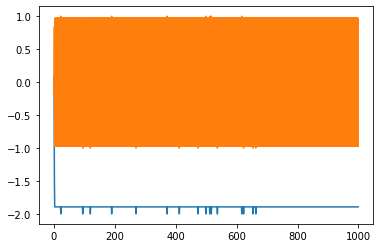

1.2599561214447021 here
0.2


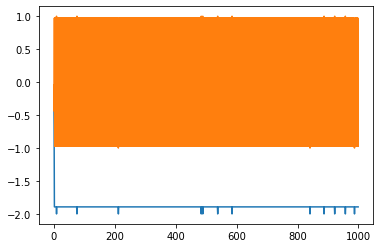

2.345034122467041 here
0.30000000000000004


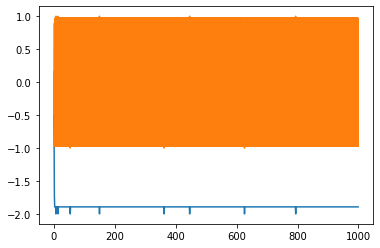

3.4423537254333496 here
0.4


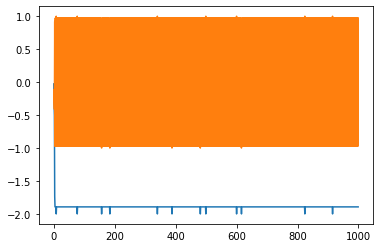

4.57421612739563 here
0.5


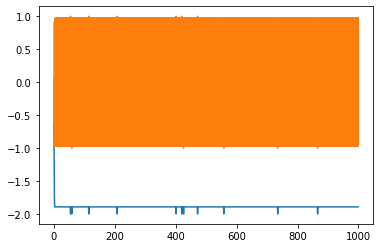

5.680351495742798 here
0.6


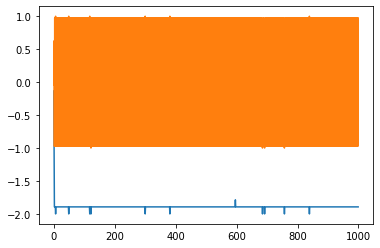

6.776033639907837 here
0.7000000000000001


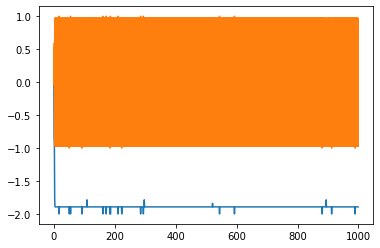

7.866875171661377 here
0.8


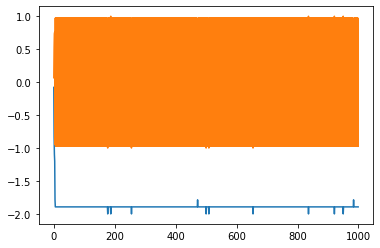

8.953117370605469 here
0.9


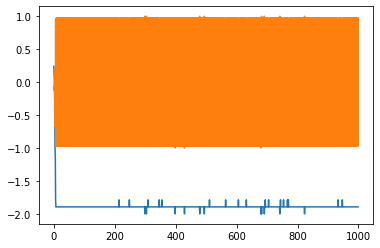

10.044190168380737 here
1.0


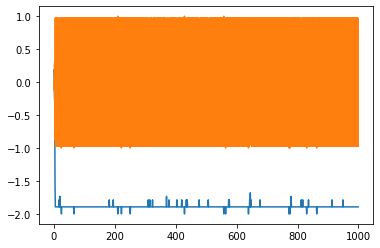

11.152191400527954 here
1.1


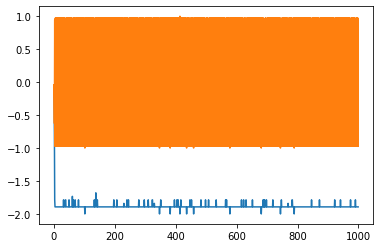

12.245280504226685 here
1.2000000000000002


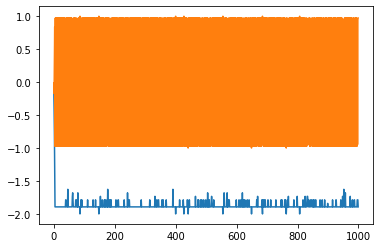

13.338170289993286 here
1.3000000000000003


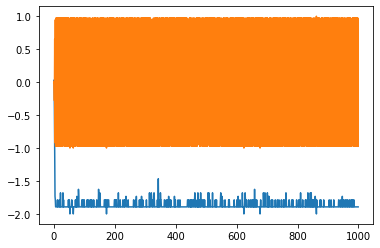

14.420926094055176 here
1.4000000000000001


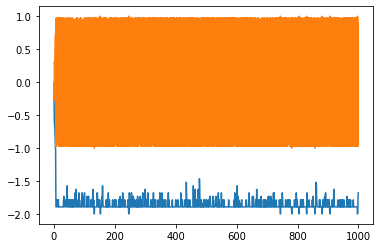

15.481318235397339 here
1.5000000000000002


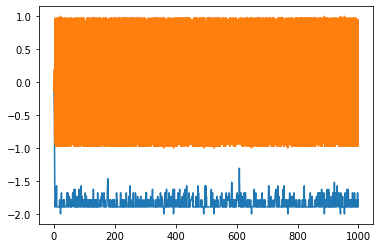

16.55753779411316 here
1.6


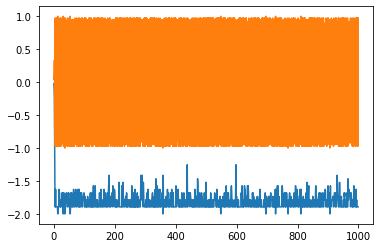

17.611304759979248 here
1.7000000000000002


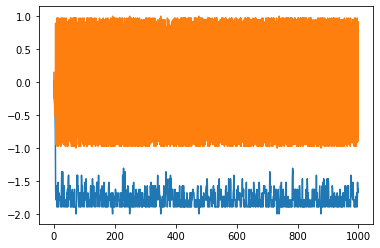

18.626405715942383 here
1.8000000000000003


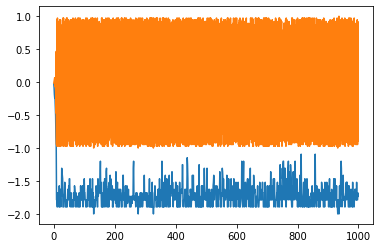

19.609183073043823 here
1.9000000000000001


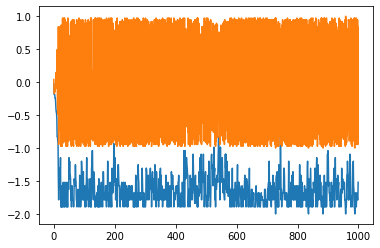

20.539438247680664 here
2.0


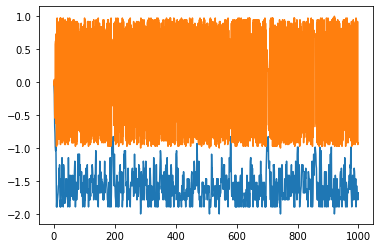

21.43450117111206 here
2.1


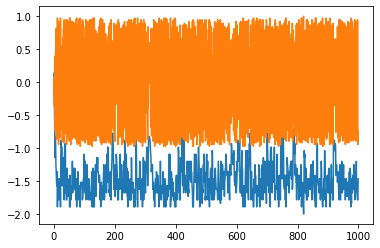

22.422776222229004 here
2.2


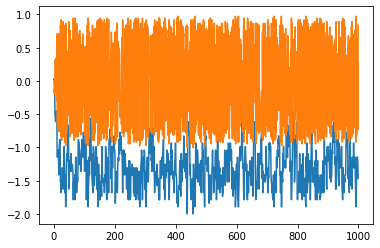

23.157690048217773 here
2.3000000000000003


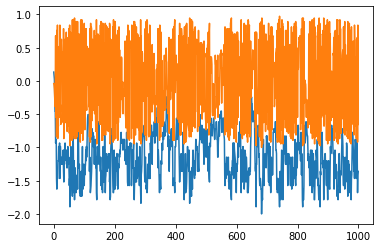

23.805744409561157 here
2.4000000000000004


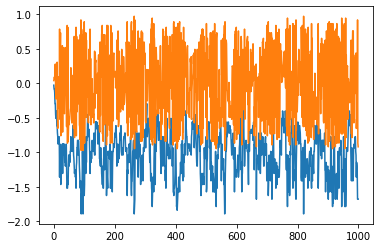

24.391632556915283 here
2.5000000000000004


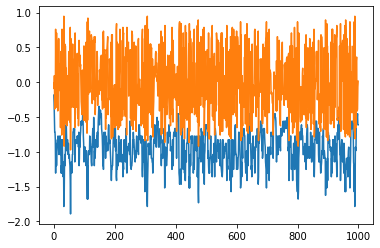

24.942211866378784 here
2.6


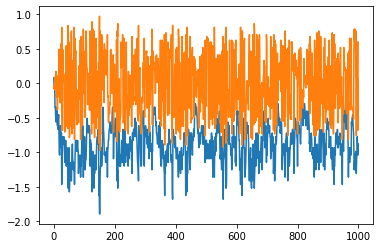

25.451261520385742 here
2.7


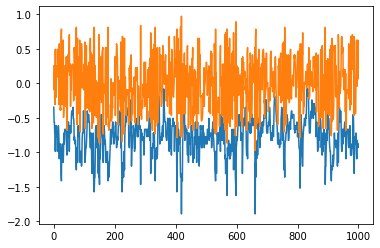

25.918302059173584 here
2.8000000000000003


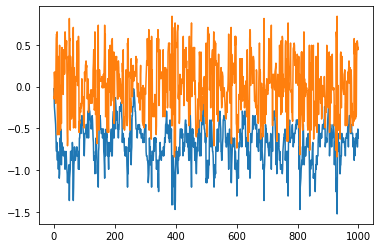

26.373119831085205 here
2.9000000000000004


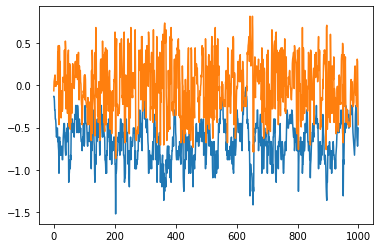

26.80993103981018 here
3.0000000000000004


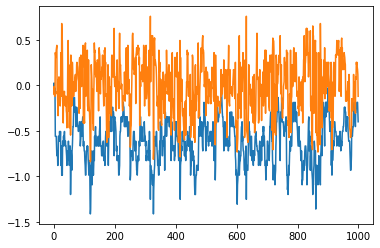

27.249261140823364 here
3.1


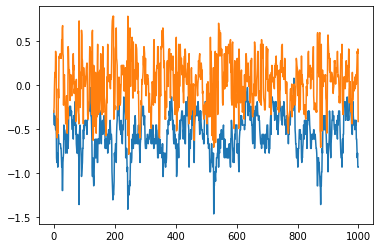

27.668200492858887 here


MessageError: ignored

In [ ]:
lattice = 'kagome'
N = 10
steps = int(1e3)
# begin_steps = int(1e2)
start_time = time.time()
J = 1
H = 0
st,et,num_t = 0.1,3.1,31 #start temperature, end temperature
# Temps = 0.1*np.ones(num_t)

# taus = np.zeros(shape = (num_t,5))
# taus1 = np.zeros(shape = (num_t,5))
Energ1s,Energ2s,Mag1s,Mag2s = np.zeros(shape = (num_t,steps)),np.zeros(shape = (num_t,steps)),np.zeros(shape = (num_t,steps)),np.zeros(shape = (num_t,steps))
# Temps[1:] = (np.linspace(st,et,num_t-1))
Temps = (np.linspace(st,et,num_t))
clusters = np.zeros(shape = (num_t,steps))
for num,T in enumerate(Temps):
  print(T)
  iT = 1/T
  iT2 = iT**2
  p  = 1.0 - np.exp(-2*iT)
  n1,n2,n3 = calc_constants(N,steps,lattice)
  E1s, M1s,E2s,M2s= np.zeros(steps) , np.zeros(steps),np.zeros(steps), np.zeros(steps)
  cluster_size = np.zeros(steps)
  E1 = M1 = E2 = M2  = M3 = acceptance = 0
  state = initial_state(N,lattice)
  # print(state)
  iT2=iT*iT            
  for i in range(steps):
      ene = calcEnergy(state,J,H,lattice)
      mag = calcMag(state)
      E1s[i],M1s[i],E2s[i],M2s[i] = ene/n3,(mag)/n3,ene**2/n3,mag**2/n3
      state,cluster_size[i] = wolff_step(state,iT,p,N,lattice)

  fig = plt.figure()
  plt.plot(np.arange(steps),E1s,M1s)
  plt.show()
  print(time.time()-start_time,"here")
  Energ1s[num] = E1s
  Energ2s[num] = E2s
  Mag1s[num]= M1s
  Mag2s[num] = M2s
  clusters[num] = cluster_size
np.savez('Wolf 10_1e4 observations {}'.format(lattice), Temps = Temps, Energ1s = Energ1s, Energ2s = Energ2s,Mag1s = Mag1s, Mag2s = Mag2s, clusters = clusters)
# files.download('Wolf 10_1e4 observations kagome.npz') #this function is used to download from colab. for that first do "from google.colab import files"

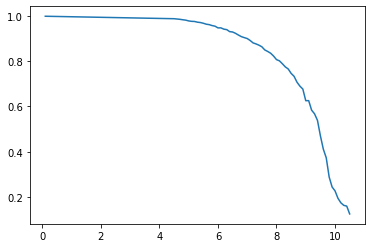

In [ ]:
plt.plot(Temps,np.abs(Mag1s).mean(axis = 1))

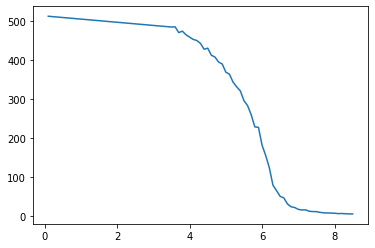

In [ ]:
plt.plot(Temps,clusters.mean(axis = 1))

In [ ]:
d = {'honey':[1,2,21],'tri' : [3,4,21],'2d' : [1.5,2.5,21],'3d' : [4,5,21]}

##look how it is changing

In [ ]:
% matplotlib qt
N =100
temp = 2.5
# N, temp     = 64, .4        # Initialse the lattice
state = initial_state(N)


msrmnt = 1001
for i in range(msrmnt):
    state = step_update(state, 1.0/temp,J,H,N)
    if i ==20: statePlot(state, i, N, 2);
    if i == 100:statePlot(state,i,N,1)

    if not i%200:
      statePlot(state,i,N,1)
    # if i == 1:       statePlot(state, i, N, 2);
    # if i == 4:       statePlot(state, i, N, 3);
    # if i == 32:      statePlot(state, i, N, 4);
    # if i == 100:     statePlot(state, i, N, 5);
    # if i == 1000:    statePlot(state, i, N, 6);
                 
    plt.show()         


# analysing

In [ ]:
'''The above functions can be called and run to calculate Energies, Magnetisations and then analyse function can be called to generate plots'''
'''first save calculated quantities using numpy.savez command'''
np.savez('filepath'+'filename.npz', Energ1s = Energ1s, Energ2s = Energ2s, Mag1s = Mag1s, Mag2s = Mag2s, temps = Temps, acceptors = acceptors)
'''loading is very similar. loaded file is a dicitonary'''
file = np.load('filepath'+'filename.npz') #this file is passed as an argument to analyse function defined below

In [ ]:
def calc_chi(Mag1s,Mag2s,Temps,n3):
  '''this uses jackknife method to calculate error to calculate magnetic susceptibility'''
    mean_cv = (Mag2s.mean(axis = 1) - (Mag1s.mean(axis = 1)**2)*(n3))/Temps
    error = np.zeros(len(mean_cv))
    for i in range(Mag1s.shape[1]):
        e1 = np.delete(Mag1s,i,1)
        e2 = np.delete(Mag2s,i,1)
        cv_cur = (e2.mean(axis = 1) - (e1.mean(axis = 1)**2)*(n3))/Temps
        error += (cv_cur-mean_cv)**2
    return mean_cv,np.sqrt(error)

def calc_cv(Energ1s,Energ2s,Temps,n3):
'''this uses jackknife method to calculate error to calculate Heat capacity'''
    mean_cv = (Energ2s.mean(axis = 1) - (Energ1s.mean(axis = 1)**2)*n3)/Temps**2
    error = np.zeros(len(mean_cv))
    for i in range(Energ1s.shape[1]):
        e1 = np.delete(Energ1s,i,1)
        e2 = np.delete(Energ2s,i,1)
        cv_cur = (e2.mean(axis = 1) - (e1.mean(axis = 1)**2)*n3)/Temps**2
        error += (cv_cur-mean_cv)**2
    return mean_cv,np.sqrt(error)

In [ ]:
def analyse(file,J,N,lattice = '2d',savefigs = False):
    Energ1s, Energ2s, Mag1s, Mag2s,Temps,acceptors = file['Energ1s'], file['Energ2s'], file['Mag1s'], file['Mag2s'],file['temps'], file['acceptors']
    num_t = len(Temps)
    _,_,n3 = calc_constants(N,1,lattice)
    CV,CVerr = calc_cv(Energ1s,Energ2s,Temps,n3)
    chi,chi_err = calc_chi(Mag1s,Mag2s,Temps,n3)
    path = 'G:/sem 8/kasi/ising/observed/graphs/'    
    
    Tc1 = Temps[np.argmax(CV)]
    Tc = Temps[np.argmax(chi)]
    
    figure = plt.figure(figsize = (10,6))
    plt.plot(Temps,CV)
    plt.errorbar(Temps,CV,CVerr,color = 'g',fmt = '.', elinewidth=1)
    plt.title('Heat Capacity, {} lattice'.format(lattice),fontsize = 16)
    plt.xlabel('Temperature',fontsize = 13)
    plt.ylabel('Heat Capcity',fontsize = 13)
    if savefigs:
        plt.savefig(path+'Heat capacity t={} {} lattice.jpg'.format(num_t,lattice))
    
    figure = plt.figure(figsize = (10,6))
    plt.plot(Temps,chi)
    plt.errorbar(Temps,chi,chi_err,color = 'g',fmt = '.', elinewidth=1)
    plt.title('Magnetic Suceptibility, {} lattice'.format(lattice),fontsize = 16)
    plt.xlabel('Temperature',fontsize = 13)
    plt.ylabel('Magnetic Suceptibility',fontsize = 13)
    if savefigs:
        plt.savefig(path+'Magnetic Suceptibility t={} {} lattice.jpg'.format(num_t,lattice))
    
    figure = plt.figure(figsize = (10,6))
    plt.plot(Temps,Energ1s.mean(axis=1))
    plt.errorbar(Temps,Energ1s.mean(axis=1),Energ1s.var(axis=1),color = 'g',fmt = '.', elinewidth=1)
    plt.title('Mean energy, {} lattice'.format(lattice),fontsize = 16)
    plt.xlabel('Temperature',fontsize = 13)
    plt.ylabel('Mean energy',fontsize = 13)
    plt.axvline(Tc,label = 'Tc = {:.2f}'.format(Tc))
    plt.legend(fontsize = 12)
    if savefigs:
        plt.savefig(path+'energy t={} {} lattice.jpg'.format(num_t,lattice))
    
    Mag1s = np.abs(Mag1s)
    figure = plt.figure(figsize = (10,6))
    plt.plot(Temps,Mag1s.mean(axis=1))
    plt.errorbar(Temps,Mag1s.mean(axis=1),Mag1s.var(axis=1),color = 'g',fmt = '.', elinewidth=1)
    plt.title('Mean Magnetisation, {} lattice'.format(lattice),fontsize = 16)
    plt.xlabel('Temperature',fontsize = 13)
    plt.ylabel('Mean Magnetisation',fontsize = 13)
    plt.axvline(Tc,label = 'Tc = {:.2f}'.format(Tc))
    plt.legend(fontsize = 12)
    if savefigs:
        plt.savefig(path+'Magnetisation t={} {} lattice.jpg'.format(num_t,lattice))
    
    figure = plt.figure(figsize = (10,6))
    plt.plot(Temps,acceptors)
    plt.title('Acceptance, {} lattice'.format(lattice),fontsize = 16)
    plt.xlabel('Temperature',fontsize = 13)
    plt.ylabel('Acceptance',fontsize = 13)
    if savefigs:
        plt.savefig(path+'Acceptance t={} {} lattice.jpg'.format(num_t,lattice))
